# Autotagging

In [1]:
import torch
import torchaudio
import IPython.display as ipd
from pathlib import Path
import pandas as pd

- Download Small MTAT if you need


In [ ]:
!pip install gdown==4.4.0
!gdown 15e9E3oZdudErkPKwb0rCAiZXkPxdZkV6
!unzip -q mtat_8000.zip

In [6]:
class MTATDataset:
  def __init__(self, dir_path, split='train', num_max_data=6000, sr=16000):
    self.dir = Path(dir_path)
    self.labels = pd.read_csv(self.dir / "meta.csv", index_col=[0])
    self.sr = sr

    if split=="train":
      sub_dir_ids = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'a', 'b', 'c']
    elif split=='valid':
      sub_dir_ids = ['d']
    else: #test
      sub_dir_ids = ['e', 'f', 'g']

    is_in_set = [True if x[0] in sub_dir_ids else False for x in self.labels['mp3_path'].values.astype('str')]
    self.labels = self.labels.iloc[is_in_set]
    self.labels = self.labels[:num_max_data]
    self.vocab = self.labels.columns.values[1:-1]
    self.label_tensor = self.convert_label_to_tensor()
  
  def convert_label_to_tensor(self):
    return torch.LongTensor(self.labels.values[:, 1:-1].astype('bool'))

  def __len__(self):
    return len(self.labels)

data_dir = Path('MTAT_SMALL')
dataset= MTATDataset(data_dir)

## Make Dataset

In [108]:
class OnFlyDataset(MTATDataset):
  def __init__(self, dir_path, split='train', num_max_data=6000, sr=16000):
    super().__init__(dir_path, split, num_max_data, sr)
#     self.resampler = torchaudio.transforms.Resample(orig_freq=22050, new_freq=self.sr)
  
  def __getitem__(self, idx):
    audio_path = self.labels['mp3_path'].iloc[idx]
    y, sr = torchaudio.load(self.dir / audio_path)
    
    if sr != self.sr:
      y = torchaudio.functional.resample(y, orig_freq=sr, new_freq=self.sr)
    
    label = self.label_tensor[idx]
    return y[0], label
    

trainset = OnFlyDataset(data_dir)
validset = OnFlyDataset(data_dir, split='valid')
testset = OnFlyDataset(data_dir, split='test')

## Make Model

In [185]:
import torch.nn as nn

class SpecModel(nn.Module):
  def __init__(self, sr, n_fft, hop_length, n_mels):
    super().__init__()
    self.mel_converter = torchaudio.transforms.MelSpectrogram(sample_rate=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)
    self.db_converter = torchaudio.transforms.AmplitudeToDB()
  def forward(self, x):
    mel_spec = self.mel_converter(x)
    db_spec = self.db_converter(mel_spec)
    db_spec = (db_spec + 40) / 100
    return db_spec

class AudioModel(nn.Module):
  def __init__(self, sr, n_fft, hop_length, n_mels, hidden_size, num_output):
    super().__init__()
    self.sr = sr
    self.spec_converter = SpecModel(sr, n_fft, hop_length, n_mels)
    self.conv_layer = nn.Sequential(
      nn.Conv1d(n_mels, out_channels=hidden_size, kernel_size=3),
      nn.MaxPool1d(3),
      nn.ReLU(),
      nn.Conv1d(hidden_size, out_channels=hidden_size, kernel_size=3),
      nn.MaxPool1d(3),
      nn.ReLU(),     
      nn.Conv1d(hidden_size, out_channels=hidden_size, kernel_size=3),
      nn.MaxPool1d(3),
      nn.ReLU(),
    )
    self.final_layer = nn.Linear(hidden_size, num_output)

  def get_spec(self, x):
    '''
    Get result of self.spec_converter
    x (torch.Tensor): audio samples (num_batch_size X num_audio_samples)
    '''
    return self.spec_converter(x)
  
  def forward(self, x):
    spec = self.get_spec(x) # num_batch X num_mel_bins X num_time_bins
    out = self.conv_layer(spec)
    out = torch.max(out, dim=-1)[0] # select [0] because torch.max outputs tuple of (value, index)
    logit = self.final_layer(out)
    prob = torch.sigmoid(logit)
    return prob
  
model = AudioModel(16000, 1024, 512, 40, 128, 50)

In [63]:
n_mels = 40
hidden_size = 64

seq_conv_layer = nn.Sequential(
      nn.Conv1d(n_mels, out_channels=hidden_size, kernel_size=5),
      nn.MaxPool1d(4),
      nn.ReLU(),
      nn.Conv1d(hidden_size, out_channels=hidden_size, kernel_size=3),
      nn.MaxPool1d(3),
      nn.ReLU(),     
      nn.Conv1d(hidden_size, out_channels=hidden_size, kernel_size=3),
      nn.MaxPool1d(3),
      nn.ReLU(),
    )



In [64]:
audio, label = trainset[0]

In [84]:
mel_spec = model.spec_converter(audio)

In [85]:
mel_spec.shape # freq_bin (channel) x time_bin  

torch.Size([40, 911])

In [86]:
model_out = seq_conv_layer(mel_spec) 
# model_out, 
model_out.shape

torch.Size([64, 24])

In [91]:
model_out.shape

torch.Size([64, 24])

In [101]:
final_test = nn.Linear(64, 50, bias=False)
test_out = final_test(model_out.T)
test_out, test_out.shape

(tensor([[-1.9713, -1.7584,  3.0312,  ..., -2.3761, -3.1079,  1.4732],
         [-1.4117, -0.7950,  0.9067,  ..., -1.1927, -1.9066,  0.0404],
         [-1.6910, -0.9139,  1.3879,  ..., -1.1623, -1.5955,  0.2827],
         ...,
         [-0.9937, -0.2435,  1.1672,  ..., -1.3833, -1.3047,  0.1060],
         [-1.0243, -0.3593,  1.2652,  ..., -1.3761, -1.3017,  0.0996],
         [-1.4774, -0.4496,  1.2401,  ..., -1.6750, -1.4967,  0.1884]],
        grad_fn=<MmBackward0>),
 torch.Size([24, 50]))

In [97]:
final_test.weight.shape

torch.Size([50, 64])

In [104]:
final_conv = nn.Conv1d(64, 50, kernel_size=1, bias=False)
final_conv.weight.data[:,:,0] = final_test.weight.data
test_out = final_conv(model_out)
test_out.T, test_out.T.shape

(tensor([[-1.9713, -1.7584,  3.0312,  ..., -2.3761, -3.1079,  1.4732],
         [-1.4117, -0.7950,  0.9067,  ..., -1.1927, -1.9066,  0.0404],
         [-1.6910, -0.9139,  1.3879,  ..., -1.1623, -1.5955,  0.2827],
         ...,
         [-0.9937, -0.2435,  1.1672,  ..., -1.3833, -1.3047,  0.1060],
         [-1.0243, -0.3593,  1.2652,  ..., -1.3761, -1.3017,  0.0996],
         [-1.4774, -0.4496,  1.2401,  ..., -1.6750, -1.4967,  0.1884]],
        grad_fn=<PermuteBackward0>),
 torch.Size([24, 50]))

In [98]:
final_conv.weight.shape

torch.Size([50, 64, 1])

In [87]:
mean_pooling = torch.mean(model_out, dim=-1)
mean_pooling, mean_pooling.shape

(tensor([    0.0000,     2.6823,     0.0000,     1.2487,     0.8096,     0.1167,
             0.7276,     0.0365,     0.0000,     0.0000,     0.1344,     1.8576,
             0.0076,     1.2481,     2.8068,     0.0295,     0.0000,     0.1667,
             0.0296,     2.3879,     0.0510,     0.0772,     3.2861,     1.5576,
             0.4737,     3.7279,     4.4033,     4.3582,     2.3644,     2.3192,
             0.2317,     0.5021,     0.1446,     0.0000,     0.0000,     0.6143,
             7.1379,     0.6086,     0.0000,     0.3253,     0.0000,     2.1696,
             0.0000,     1.1167,     5.6040,     0.0143,     0.3262,     0.0161,
             6.1156,     0.0008,     0.0000,     0.0000,     0.4237,     1.8557,
             3.6960,     0.8464,     0.5737,     0.0186,     0.0000,     0.0136,
             0.0000,     0.0720,     3.8648,     0.0340],
        grad_fn=<MeanBackward1>),
 torch.Size([64]))

In [88]:
max_pooling = torch.max(model_out, dim=-1).values
max_pooling, max_pooling.shape

(tensor([    0.0000,     4.3618,     0.0000,     1.7843,     1.6946,     1.2563,
             1.9779,     0.8471,     0.0000,     0.0000,     1.3759,     4.5051,
             0.1820,     2.2768,     3.9449,     0.3172,     0.0000,     3.4557,
             0.2560,     9.2989,     0.5654,     1.0495,     8.2116,     2.4553,
             2.4427,    10.3835,     7.7901,    10.0643,     2.8923,     6.2799,
             0.9667,     1.9399,     1.1106,     0.0000,     0.0000,     6.5254,
            12.6467,     1.4461,     0.0000,     0.9304,     0.0000,     7.5213,
             0.0000,     2.1392,     8.5439,     0.3008,     1.1191,     0.2249,
            10.7428,     0.0197,     0.0000,     0.0000,     1.3934,     8.3979,
             9.0301,     4.3973,     2.4469,     0.4472,     0.0000,     0.2360,
             0.0000,     0.9428,     8.2263,     0.8164],
        grad_fn=<MaxBackward0>),
 torch.Size([64]))

In [106]:
num_tags =50
final_layer = nn.Linear(hidden_size, num_tags)

logit = final_layer(max_pooling)
prob = torch.sigmoid(logit)
prob

tensor([0.1311, 0.7329, 0.4924, 0.8794, 0.9831, 0.0637, 0.1600, 0.7370, 0.0756,
        0.9173, 0.1240, 0.6647, 0.5417, 0.0132, 0.2898, 0.8197, 0.2933, 0.3307,
        0.9620, 0.3096, 0.9809, 0.0791, 0.2901, 0.2951, 0.9589, 0.6640, 0.1681,
        0.6536, 0.0059, 0.5650, 0.0582, 0.9303, 0.0486, 0.0801, 0.7539, 0.6463,
        0.1736, 0.8508, 0.3785, 0.8584, 0.3372, 0.6312, 0.9199, 0.9402, 0.0281,
        0.1385, 0.9992, 0.1298, 0.9094, 0.2188], grad_fn=<SigmoidBackward0>)

## Train!

In [110]:
from torch.utils.data import DataLoader

train_loader = DataLoader(trainset, batch_size=32, shuffle=True, num_workers=4)
valid_loader = DataLoader(validset, batch_size=64, shuffle=False, num_workers=4)
test_loader = DataLoader(testset, batch_size=64, shuffle=False, num_workers=4)

batch = next(iter(train_loader))
batch

[tensor([[     0.0000,      0.0000,      0.0000,  ...,      0.0000,
               0.0000,      0.0000],
         [     0.0000,      0.0000,      0.0000,  ...,      0.0000,
               0.0000,      0.0000],
         [     0.0000,      0.0000,      0.0000,  ...,     -0.0000,
              -0.0000,     -0.0000],
         ...,
         [     0.0000,      0.0000,      0.0000,  ...,     -0.0000,
               0.0000,      0.0000],
         [     0.0000,      0.0000,      0.0000,  ...,     -0.0000,
              -0.0000,     -0.0000],
         [     0.0000,      0.0000,      0.0000,  ...,      0.0000,
              -0.0000,     -0.0000]]),
 tensor([[0, 0, 0,  ..., 0, 0, 0],
         [0, 1, 0,  ..., 0, 0, 1],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]])]

In [186]:
from tqdm import tqdm

model = AudioModel(16000, 1024, 512, 40, 128, 50)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

num_epochs = 10
criterion = torch.nn.BCELoss()
device = 'cuda'

model.to(device)
loss_record2 = []

for epoch in tqdm(range(num_epochs)):
  for batch in train_loader:
    audio, label = batch
    pred = model(audio.to(device))
    loss = criterion(pred, label.float().to(device))
    loss.backward()
    optimizer.step()

    optimizer.zero_grad()
    loss_record2.append(loss.item())

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [02:14<00:00, 13.45s/it]


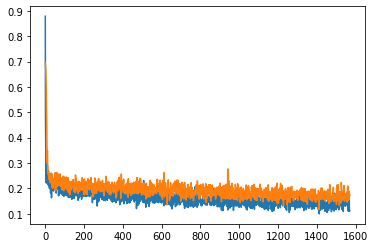

In [188]:
import matplotlib.pyplot as plt
plt.plot(loss_record)
plt.plot(loss_record2)

In [121]:
test_batch = next(iter(test_loader))


In [164]:
audio, label = test_batch
pred = model(audio.to(device)).cpu()




In [134]:
torch.rand_like(pred)

tensor([[0.0396, 0.5034, 0.0745,  ..., 0.4454, 0.4634, 0.9688],
        [0.2074, 0.5072, 0.3586,  ..., 0.0365, 0.3387, 0.3208],
        [0.0126, 0.3417, 0.1935,  ..., 0.0370, 0.4747, 0.9904],
        ...,
        [0.0849, 0.6115, 0.1424,  ..., 0.9110, 0.2014, 0.1680],
        [0.5989, 0.0939, 0.5845,  ..., 0.3240, 0.8580, 0.2715],
        [0.4019, 0.7087, 0.7230,  ..., 0.0338, 0.7647, 0.1140]])

In [141]:
threshold = 0.5
# rand_pred = torch.rand_like(pred)
pred_thresh = (pred > threshold)
match_or_not = pred_thresh == label 

match_or_not.sum() / (pred.shape[0] * pred.shape[1])


# pred[0] > threshold, label[0]

tensor(0.9350)

In [148]:
torch.where(pred_thresh[0])[0]

tensor([ 7, 36, 38])

In [156]:
sample_id = 3
print(trainset.vocab[torch.where(pred_thresh[sample_id])[0]])

audio, label = testset[sample_id]
ipd.display(ipd.Audio(audio, rate=testset.sr))

['harpsichord' 'classical']


In [173]:
def get_tpr_fpr(pred, target, threshold):
  thresh_pred = pred > threshold
  
  num_total_gt_true = target.sum()
  num_total_gt_false = (1-target).sum()
  num_true_positive = ((target==1) * (thresh_pred==1)).sum()
  num_false_positive = ((target==0) * (thresh_pred==1)).sum()
  
  true_positive_ratio = num_true_positive / num_total_gt_true
  false_positive_ratio = num_false_positive / num_total_gt_false
  return true_positive_ratio.item(), false_positive_ratio.item()

get_tpr_fpr(pred, label, threshold=0.5)

(0.23853211104869843, 0.014084506779909134)

In [180]:
roc = [ get_tpr_fpr(pred, label, i/100) for i in range(100)]
roc[:10]

[(1.0, 1.0),
 (0.963302731513977, 0.41985243558883667),
 (0.9174311757087708, 0.2994634509086609),
 (0.8899082541465759, 0.23675385117530823),
 (0.8623853325843811, 0.1965124011039734),
 (0.8211008906364441, 0.1696847826242447),
 (0.78899085521698, 0.14855802059173584),
 (0.7660550475120544, 0.13112005591392517),
 (0.7339449524879456, 0.12206573039293289),
 (0.7018348574638367, 0.10898725688457489)]

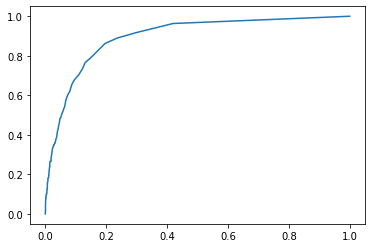

In [177]:
plt.plot([x[1] for x in roc], [x[0] for x in roc])

In [165]:
label

tensor([[1, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [1, 0, 0,  ..., 0, 0, 0],
        [1, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]])

In [114]:
pred.shape

torch.Size([32, 50])

In [71]:
torch.set_printoptions(sci_mode=False)

## Data Normalization

In [182]:
mel_spec, torch.max(mel_spec), torch.min(mel_spec)

(tensor([[-100.0000, -100.0000, -100.0000,  ...,  -10.4038,  -17.3291,
           -95.0076],
         [-100.0000, -100.0000, -100.0000,  ...,   -6.9640,  -20.0798,
           -93.2516],
         [-100.0000, -100.0000, -100.0000,  ...,   -2.6647,  -23.2004,
           -89.7118],
         ...,
         [-100.0000, -100.0000, -100.0000,  ...,  -15.7794,  -32.1459,
          -100.0000],
         [-100.0000, -100.0000, -100.0000,  ...,  -14.7002,  -30.2317,
          -100.0000],
         [-100.0000, -100.0000, -100.0000,  ...,  -14.7623,  -35.6972,
          -100.0000]]),
 tensor(28.3778),
 tensor(-100.))

In [183]:
(mel_spec + 40) / 100

tensor([[-0.6000, -0.6000, -0.6000,  ...,  0.2960,  0.2267, -0.5501],
        [-0.6000, -0.6000, -0.6000,  ...,  0.3304,  0.1992, -0.5325],
        [-0.6000, -0.6000, -0.6000,  ...,  0.3734,  0.1680, -0.4971],
        ...,
        [-0.6000, -0.6000, -0.6000,  ...,  0.2422,  0.0785, -0.6000],
        [-0.6000, -0.6000, -0.6000,  ...,  0.2530,  0.0977, -0.6000],
        [-0.6000, -0.6000, -0.6000,  ...,  0.2524,  0.0430, -0.6000]])

## How CNN works

In [22]:
dummy = torch.randint(-3, 4, (6,7)).float()
dummy = dummy.unsqueeze(0)
dummy, dummy.shape

(tensor([[[ 3., -3., -1., -3.,  3., -1.,  0.],
          [ 0., -2.,  3., -3., -3.,  1., -1.],
          [ 0., -2., -3., -2.,  1., -2.,  1.],
          [-1.,  1.,  1., -1.,  0.,  1.,  1.],
          [ 1.,  2., -2., -1.,  1., -1., -3.],
          [-3.,  2., -3.,  1.,  3., -1.,  2.]]]),
 torch.Size([1, 6, 7]))

In [16]:
conv_layer = nn.Conv2d(1, 1, kernel_size=3, bias=False)

In [20]:
conv_layer.weight.shape
conv_layer.weight.data = torch.randint(-1, 2, (1,1,3,3)).float()
conv_layer.weight

Parameter containing:
tensor([[[[-1.,  1.,  0.],
          [-1.,  1.,  0.],
          [ 1.,  1.,  1.]]]], requires_grad=True)

In [25]:
'''
2D Conv Layer의 입력은 3차원

'''
dummy, conv_layer.weight, conv_layer(dummy)

(tensor([[[ 3., -3., -1., -3.,  3., -1.,  0.],
          [ 0., -2.,  3., -3., -3.,  1., -1.],
          [ 0., -2., -3., -2.,  1., -2.,  1.],
          [-1.,  1.,  1., -1.,  0.,  1.,  1.],
          [ 1.,  2., -2., -1.,  1., -1., -3.],
          [-3.,  2., -3.,  1.,  3., -1.,  2.]]]),
 Parameter containing:
 tensor([[[[-1.,  1.,  0.],
           [-1.,  1.,  0.],
           [ 1.,  1.,  1.]]]], requires_grad=True),
 tensor([[[-13.,   0., -12.,   3.,   0.],
          [ -3.,   5.,  -5.,   3.,   3.],
          [  1.,  -2.,  -3.,   3.,  -5.],
          [ -1.,  -4.,   0.,   6.,   3.]]], grad_fn=<SqueezeBackward1>))

In [26]:
conv_layer(dummy[:, 0:3, 1:4])

tensor([[[0.]]], grad_fn=<SqueezeBackward1>)

In [41]:
num_ch = 4
dummy = torch.randint(-3, 4, (num_ch, 10)).float()
dummy

tensor([[ 2., -3.,  0., -3.,  0.,  2.,  2., -1.,  3.,  1.],
        [-2., -1.,  3., -3.,  2.,  0.,  0.,  2.,  3., -3.],
        [ 1., -2., -3.,  0.,  1.,  3., -3.,  1.,  3., -2.],
        [-1., -2., -2., -3.,  0., -3., -3., -1.,  1.,  3.]])

In [46]:
out_ch = 6
conv1d = nn.Conv1d(num_ch, out_ch, kernel_size=3, bias=False)
conv1d.weight.data = torch.randint(-1, 2, conv1d.weight.shape).float()
conv1d.weight

Parameter containing:
tensor([[[-1.,  1., -1.],
         [ 0.,  0., -1.],
         [ 1.,  0.,  1.],
         [ 0.,  0.,  0.]],

        [[-1.,  1., -1.],
         [-1.,  1., -1.],
         [ 0.,  1.,  0.],
         [ 1., -1.,  1.]],

        [[ 1., -1., -1.],
         [ 1.,  1.,  1.],
         [-1.,  1., -1.],
         [ 0.,  1.,  1.]],

        [[-1.,  1.,  1.],
         [-1., -1., -1.],
         [-1., -1., -1.],
         [ 1.,  1.,  1.]],

        [[ 1.,  1.,  1.],
         [-1.,  0.,  0.],
         [ 0.,  1.,  1.],
         [ 1., -1.,  1.]],

        [[ 0.,  1., -1.],
         [ 0.,  0., -1.],
         [ 0.,  0., -1.],
         [-1., -1.,  1.]]], requires_grad=True)

In [47]:
out = conv1d(dummy)
out, out.shape

(tensor([[-10.,   7.,  -7.,   4.,  -2.,   3.,  -9.,   5.],
         [-10.,   7., -10.,   1.,   1.,  -5.,  -7.,  11.],
         [  1.,  -7.,   4., -11.,  -3.,  -8.,   6.,   5.],
         [ -6.,  -1.,  -8.,  -4.,  -5., -11.,  -9.,   4.],
         [ -5., -11.,  -4.,   0.,   2.,   0.,   7.,   3.],
         [ -2.,   7.,  -1.,  -5.,   3.,   5.,  -5.,  10.]],
        grad_fn=<SqueezeBackward1>),
 torch.Size([6, 8]))

In [52]:
max_pool_layer = nn.MaxPool1d(3)

In [53]:
after_pool = max_pool_layer(out)
after_pool, after_pool.shape

(tensor([[ 7.,  4.],
         [ 7.,  1.],
         [ 4., -3.],
         [-1., -4.],
         [-4.,  2.],
         [ 7.,  5.]], grad_fn=<SqueezeBackward1>),
 torch.Size([6, 2]))

## Batch Norm

In [187]:
audio

tensor([[     0.0000,      0.0000,      0.0000,  ...,      0.0000,
             -0.0000,     -0.0000],
        [     0.0000,      0.0000,      0.0000,  ...,     -0.0000,
             -0.0000,     -0.0000],
        [     0.0000,      0.0000,      0.0000,  ...,     -0.0000,
              0.0000,      0.0000],
        ...,
        [     0.0000,      0.0000,      0.0000,  ...,      0.0000,
              0.0000,      0.0000],
        [     0.0000,      0.0000,      0.0000,  ...,     -0.0000,
             -0.0000,     -0.0000],
        [     0.0000,      0.0000,      0.0000,  ...,     -0.0000,
             -0.0000,     -0.0000]])

In [ ]:
model.train()
model.eval()